## Generative AI Assignment 2
## Dr. Hajra Waheed

### Muhammad Rohan Javed
### L21-5625

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
!pip install datasets
from datasets import load_dataset
!pip install transformers
from transformers import ViTForImageClassification, ViTImageProcessor
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from PIL import Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.4 MB/s eta 0:00:00


### Part 1:

**Spoof Detection (ViT)**




In [ ]:
dataset = load_dataset("nguyenkhoa/celeba-spoof-for-face-antispoofing-test")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/437 [00:00<?, ?B/s]

test-00000-of-00010.parquet:   0%|          | 0.00/496M [00:00<?, ?B/s]

test-00001-of-00010.parquet:   0%|          | 0.00/493M [00:00<?, ?B/s]

test-00002-of-00010.parquet:   0%|          | 0.00/494M [00:00<?, ?B/s]

test-00003-of-00010.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

test-00004-of-00010.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

test-00005-of-00010.parquet:   0%|          | 0.00/499M [00:00<?, ?B/s]

test-00006-of-00010.parquet:   0%|          | 0.00/500M [00:00<?, ?B/s]

test-00007-of-00010.parquet:   0%|          | 0.00/498M [00:00<?, ?B/s]

test-00008-of-00010.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

test-00009-of-00010.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/67170 [00:00<?, ? examples/s]

**Data reduction**

In [ ]:
print(dataset)

def reduce_dataset(dataset, fraction=0.2):
    split_name = "test"  # Use "test" since it's the only available split
    total_samples = len(dataset[split_name])
    reduced_size = int(total_samples * fraction)
    dataset[split_name] = dataset[split_name].shuffle(seed=42).select(range(reduced_size))
    return dataset


dataset = reduce_dataset(dataset)


DatasetDict({
    test: Dataset({
        features: ['cropped_image', 'labels', 'labelNames'],
        num_rows: 67170
    })
})


In [ ]:
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

def transform(example):
    image = example["cropped_image"]

    # Skip None images
    if image is None:
        return None  # This tells `.map()` to drop the example

    inputs = processor(images=image, return_tensors="pt")
    label = torch.tensor(example["labels"])  # Ensure correct label extraction
    return {"pixel_values": inputs["pixel_values"].squeeze(0), "label": label}

dataset = dataset.map(transform, remove_columns=["cropped_image", "labelNames"], batched=False)




Map:   0%|          | 0/13434 [00:00<?, ? examples/s]

In [ ]:

print(len(dataset['test']))


13348


In [ ]:
def collate_fn(batch):
    pixel_values = torch.stack([torch.tensor(item["pixel_values"]) for item in batch])  # Convert to tensor
    labels = torch.tensor([item["label"] for item in batch])
    return {"pixel_values": pixel_values, "labels": labels}


**training**

In [ ]:
train_size = int(0.8 * len(dataset["test"]))
val_size = len(dataset["test"]) - train_size
train_dataset, val_dataset = random_split(dataset["test"], [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [ ]:
model_vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=2)
optimizer = optim.Adam(model_vit.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

In [ ]:
batch = next(iter(train_loader))  # Get one batch from the DataLoader
for i, item in enumerate(batch["pixel_values"]):
    print(f"Item {i}: {type(item)}")


Item 0: <class 'torch.Tensor'>
Item 1: <class 'torch.Tensor'>
Item 2: <class 'torch.Tensor'>
Item 3: <class 'torch.Tensor'>
Item 4: <class 'torch.Tensor'>
Item 5: <class 'torch.Tensor'>
Item 6: <class 'torch.Tensor'>
Item 7: <class 'torch.Tensor'>
Item 8: <class 'torch.Tensor'>
Item 9: <class 'torch.Tensor'>
Item 10: <class 'torch.Tensor'>
Item 11: <class 'torch.Tensor'>
Item 12: <class 'torch.Tensor'>
Item 13: <class 'torch.Tensor'>
Item 14: <class 'torch.Tensor'>
Item 15: <class 'torch.Tensor'>


In [ ]:
def train_vit(model, train_loader, criterion, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}: Loss = {loss.item()}")


Epoch 1: Loss 0.07992196429944681, Accuracy 0.9714365986139727
Epoch 2: Loss 0.02027404549968022, Accuracy 0.9940063682337517
Epoch 3: Loss 0.013952435031139382, Accuracy 0.9953174751826185


In [ ]:
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            pixel_values, labels = batch["pixel_values"].to(device), batch["labels"].to(device)
            outputs = model(pixel_values)
            preds = outputs.logits.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

evaluate(model, val_loader)

Accuracy: 0.9963, Precision: 0.9973, Recall: 0.9973, F1-score: 0.9973


**Testing**

In [ ]:
# Test with a real and spoofed photo
def test_image(image_path, model):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    outputs = model(inputs["pixel_values"])
    pred = outputs.logits.argmax(1).item()
    print(f"Prediction: {'Real' if pred == 0 else 'Spoof'}")

test_image("/content/WhatsApp Image 2023-10-20 at 01.33.44.jpg", model)  # Add your real photo
test_image("/content/Screenshot 2025-03-06 025453.png", model)  # Add a spoofed photo

Prediction: Real
Prediction: Spoof


### Part 2:

**CLIP**

libraries

In [1]:
import os
import zipfile
import torch
!pip install clip
import clip
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
import os
print(os.listdir('/content/'))

['.config', 'val2017', 'person_keypoints_train2017.json.zip', 'captions_val2017.json.zip', 'captions_val2017.json', 'person_keypoints_val2017.json.zip', 'captions_train2017.json.zip', 'instances_train2017.json.zip', 'val2017.zip', 'instances_val2017.json.zip', 'sample_data']


In [4]:
coco_images_zip = "/content/val2017.zip"
coco_images_dir = "val2017/"
if not os.path.exists(coco_images_dir):
    with zipfile.ZipFile(coco_images_zip, 'r') as zip_ref:
        zip_ref.extractall()

annotations_zip = "captions_val2017.json.zip"
annotations_file = "captions_val2017.json"
if not os.path.exists(annotations_file):
    with zipfile.ZipFile(annotations_zip, 'r') as zip_ref:
        zip_ref.extractall()


In [6]:
with open(annotations_file, 'r') as f:
    captions_data = json.load(f)

# Map image IDs to captions
image_id_to_captions = {}
for ann in captions_data["annotations"]:
    image_id = ann["image_id"]
    caption = ann["caption"]
    if image_id not in image_id_to_captions:
        image_id_to_captions[image_id] = []
    image_id_to_captions[image_id].append(caption)

In [7]:
!pip install --upgrade git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-vodrlnau
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-vodrlnau
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
import clip
import open_clip  

In [9]:
model, preprocess, tokenizer = open_clip.create_model_and_transforms("ViT-B/32", pretrained="openai", device=device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


In [10]:
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import default_loader

# Custom dataset to load images directly from val2017 folder
class CocoImageDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.image_paths = [os.path.join(root, fname) for fname in os.listdir(root) if fname.endswith(('.jpg', '.jpeg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Ensure it's RGB
        if self.transform:
            image = self.transform(image)
        return image, img_path  # Return both image and path

# Use the custom dataset
dataset = CocoImageDataset(root="val2017/", transform=preprocess)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)


In [11]:
image_features = []
image_paths = []
with torch.no_grad():
    for images, paths in tqdm(dataloader, desc="Processing Images"):
        images = images.to(device)
        features = model.encode_image(images)
        image_features.append(features)
        image_paths.extend(paths)  # Fix: Collect paths correctly

image_features = torch.cat(image_features).float()
image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize

Processing Images: 100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


In [12]:
def retrieve_images(query, top_k=5):
    text = clip.tokenize([query]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    similarities = (text_features @ image_features.T).squeeze(0)  # Cosine similarity
    top_k_indices = similarities.topk(top_k).indices.cpu().numpy()

    return [(image_paths[i], similarities[i].item()) for i in top_k_indices]

In [13]:
def display_results(query, top_images):
    fig, axes = plt.subplots(1, len(top_images), figsize=(15, 5))
    fig.suptitle(f"Query: {query}", fontsize=14)

    for ax, (image_path, score) in zip(axes, top_images):
        img = Image.open(image_path)
        ax.imshow(img)
        ax.set_title(f"Score: {score:.4f}")
        ax.axis("off")

    plt.show()

testing


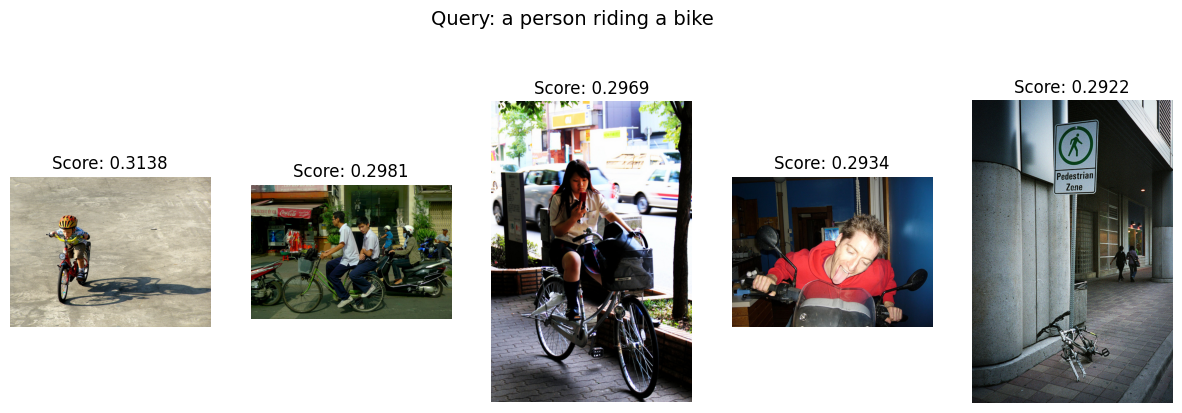

In [14]:
query = "a person riding a bike"
top_images = retrieve_images(query)
display_results(query, top_images)


### Part 3:

**Stable Diffusion**

In [16]:
import torch
!pip install diffusers
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image

In [17]:
def load_model():
    model_id = "runwayml/stable-diffusion-v1-5"  # Pre-trained model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(device)
    return pipe

In [18]:
def generate_variations(pipe, image_path, prompt, strength=0.75, guidance_scale=7.5, num_inference_steps=50):
    init_image = Image.open(image_path).convert("RGB").resize((512, 512))

    images = pipe(
        prompt=prompt,
        image=init_image,
        strength=strength,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps
    ).images

    return images[0]

In [ ]:
def experiment_parameters(pipe, image_path, prompt):
    

    # Define various parameter sets for testing
    param_variations = [
        {"strength": 0.4, "guidance_scale": 4.0, "num_inference_steps": 25},
        {"strength": 0.6, "guidance_scale": 6.5, "num_inference_steps": 40},
        {"strength": 0.8, "guidance_scale": 8.0, "num_inference_steps": 55},
        {"strength": 1.0, "guidance_scale": 12.0, "num_inference_steps": 75},
    ]

    results = []

    for params in param_variations:
        print(f"Generating image with: Strength={params['strength']}, "
              f"Guidance Scale={params['guidance_scale']}, Steps={params['num_inference_steps']}")

        try:
            image = generate_variations(pipe, image_path, prompt, **params)
            results.append((params, image))
        except Exception as e:
            print(f"Error generating image with params {params}: {e}")

    return results


In [ ]:
def prompt_engineering(pipe, image_path):
    prompts = [
        "a watercolor painting of the image",
        "a pixel art version of the image",
        "an abstract surreal artwork inspired by Salvador Dalí",
        "a post-impressionist painting inspired by Van Gogh",
        "a futuristic cyberpunk cityscape with neon lights",
        "a fantasy medieval castle scene",
        "a hyper-realistic cinematic frame",
        "a minimalist black and white sketch"
    ]

    results = []
    for i, prompt in enumerate(prompts):
        print(f"Generating variation {i+1}: {prompt}")
        image = generate_variations(pipe, image_path, prompt)
        results.append((prompt, image))

    return results


In [ ]:
import os

def main():
    # Load the model
    pipe = load_model()

    
    image_path = 'input_image.png'  

    # Experiment with different parameter settings
    print("Running parameter experiments...")
    param_results = experiment_parameters(pipe, image_path, "a breathtaking fantasy world")

    # Save generated images from parameter tuning
    output_dir = "generated_images"
    os.makedirs(output_dir, exist_ok=True)

    for params, image in param_results:
        file_name = f"param_{params['strength']}_{params['guidance_scale']}.png"
        save_path = os.path.join(output_dir, file_name)
        image.save(save_path)
        print(f"Saved: {save_path}")

    # Generate variations using diverse prompts
    print("Creating images with different styles...")
    prompt_results = prompt_engineering(pipe, image_path)

    # Save images generated from different prompts
    for prompt, image in prompt_results:
        sanitized_prompt = "".join(c if c.isalnum() else "_" for c in prompt)  # Clean filename
        file_name = f"prompt_{sanitized_prompt}.png"
        save_path = os.path.join(output_dir, file_name)
        image.save(save_path)
        print(f"Saved: {save_path}")

if __name__ == "__main__":
    main()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Experimenting with different parameters:


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Generating images for different prompts:


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]